In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import multiprocessing
import jax
import jax.random as jr


os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={multiprocessing.cpu_count()}"
# os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={10}"
jax.config.update('jax_platform_name', 'cpu')
platform = jax.lib.xla_bridge.get_backend().platform.casefold()
print("Platform: ", platform)
print(len(jax.devices()))

Platform:  cpu
28


In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open

from cohlib.utils import rotate_eigvecs, naive_estimator, add0
import cohlib.confs.utils as conf

In [4]:
def plot_latent_sim_data(ax, K, L, seed, rankname='rank1', gamma_seed=0, color='tab:blue', ell=0, unit=0, alpha=0.5):
    if ax is None: 
        ax = plt.gca()

    latent_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/latent_sim.pkl'

    latent_load = pickle_open(latent_path)
    zs_nz = latent_load['zs_nz']
    nz = latent_load['nz']
    freqs = latent_load['freqs']
    num_freqs = freqs.size
    lcfg = latent_load['lcfg']
    lcfg = conf.omega(lcfg)

    zs = jnp.zeros((num_freqs, lcfg.K, lcfg.L), dtype=complex)
    zs = zs.at[nz,:,:].set(zs_nz)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    xvals = jnp.arange(xs.shape[0]) / 1000
    ax.plot(xvals, xs[:,unit,ell], color='tab:blue', alpha=alpha)

def plot_obs_sim_data(ax, K, L, seed, mu, rankname='rank1', gamma_seed=0, color='tab:blue', ell=0, unit=0, alpha=0.5):
    if ax is None: 
        ax = plt.gca()

    obs_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/obs_sim.pkl'
    obs_load = pickle_open(obs_path)
    obs = obs_load['obs']

    xvals = jnp.arange(obs.shape[0]) / 1000
    ax.plot(xvals, obs[:,unit,ell], color='tab:blue', alpha=alpha)

In [5]:
def load_latent_data(K, L, seed, rankname='rank1', gamma_seed=0):
    latent_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/latent_sim.pkl'

    latent_load = pickle_open(latent_path)
    zs_nz = latent_load['zs_nz']
    nz = latent_load['nz']
    freqs = latent_load['freqs']
    num_freqs = freqs.size
    lcfg = latent_load['lcfg']
    lcfg = conf.omega(lcfg)

    zs = jnp.zeros((num_freqs, lcfg.K, lcfg.L), dtype=complex)
    zs = zs.at[nz,:,:].set(zs_nz)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    return latent_load, xs

def load_obs_data(K, L, seed, mu, rankname='rank1', gamma_seed=0):
    obs_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/obs_sim.pkl'
    obs_load = pickle_open(obs_path)
    # obs = obs_load['obs']

    return obs_load

def get_theta_label(ocfg, theta):
    if ocfg.obs_type == 'gaussian':
        label = f'{ocfg.ov1}e{theta}'
    elif ocfg.obs_type in ['pp_relu', 'pp_log']:
        label = f'mu = {theta}'
    else:
        return ValueError
    return label

def get_ccn_fullrank_eigvals(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    eigvals_raw, _ = jnp.linalg.eigh(gamma)
    eigvals = eigvals_raw[:,::-1]
    return eigvals

In [6]:
# for mu in 0.8 1.5 2.4 3.1
seed = 0
mu = 3.1
latent_load, xs = load_latent_data(3, 25, seed, rankname='rank1', gamma_seed=0)
obs_load = load_obs_data(3, 25, seed, mu, rankname='rank1', gamma_seed=0)
obs = obs_load['obs']
print(obs.sum(0).mean(1))

FileNotFoundError: [Errno 2] No such file or directory: '/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/window1000/gseed0/K3/L25/lseed0/latent_sim.pkl'

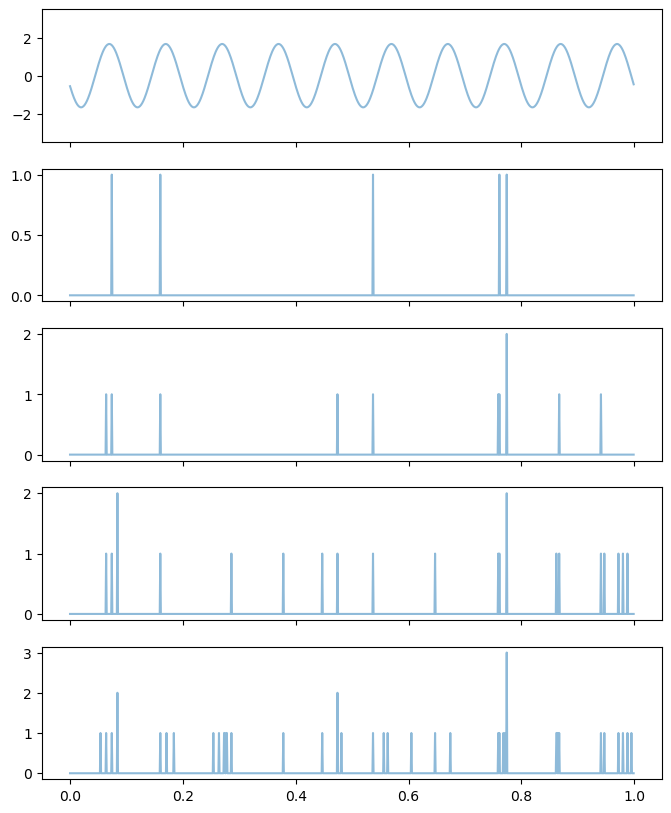

In [ ]:
seed = 0
lshow = 1
fig, axs = plt.subplots(5,1,figsize=(8,10), sharex=True)

plot_latent_sim_data(axs[0], 3, 25, seed, ell=lshow, rankname='rank1', gamma_seed=0)
axs[0].set_ylim(-3.5, 3.5)

for i, mu in enumerate([0.8, 1.5, 2.4, 3.1]):
    plot_obs_sim_data(axs[i+1], 3, 25, seed, mu, ell=lshow, rankname='rank1', gamma_seed=0)
    # axs[i,1].set_ylim(-3.5, 3.5)


In [13]:
def mod_config(cfg, K, L, theta):
    cfg.latent.K = K
    cfg.latent.L = L
    if cfg.obs.obs_type == 'gaussian':
        cfg.obs.ov2 = theta
    elif cfg.obs.obs_type in ['pp_relu', 'pp_log']:
        cfg.obs.mu = theta
    else:
        raise ValueError

    return cfg


# ID NaN seeds / trials

In [7]:
def get_sampling_dict(func, cfg, K, L, theta, seeds):
    cfg = mod_config(cfg, K, L, theta)
    sampling_data = {}
    sampling_data['true'] = []
    sampling_data['oracle'] = []
    sampling_data['model'] = []
    sampling_data['naive'] = []
    for s, seed_use in enumerate(seeds):
        true, oracle, model, naive = func(cfg, seed_use)
        sampling_data['true'].append(true) 
        sampling_data['oracle'].append(oracle)
        sampling_data['model'].append(model)
        sampling_data['naive'].append(naive)

    return sampling_data

In [8]:
from cohlib.plot import get_eigval
def eigval1(cfg, seed, eigrank=1, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}
    model_dir = conf.get_model_dir(cfg, temp_params)

    res = pickle_open(os.path.join(model_dir, 'res.pkl'))

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    eigval_true = lrccn_true.eigvals[0,eigrank-1]

    eigval_model = get_ccn_fullrank_eigvals(res['ccn_est'])[0,eigrank-1]

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigval_oracle = get_eigval(gamma_oracle[jind_nz,:,:], eigrank)

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    eigval_naive = get_eigval(naive_est[jind_nz,:,:], eigrank)

    return eigval_true, eigval_oracle, eigval_model, eigval_naive

# L = 5; mu = 0.8; K = 3
# get and store naive; oracle; true; model values


In [18]:
# Get base cfg to modify
gseed_use = 0
seed_use = 0
# scale_power = int(1e6)
# temp = f"/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale{scale_power}/window1000/gseed0/K3/L5/lseed0/obs-pp_log/mu0.8/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
scale_power = int(2e5)
temp = f"/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale{scale_power}/window1000/gseed0/K25/L5/lseed0/obs-pp_log/mu3.0/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
res = pickle_open(temp)
cfg = conf.omega(res['cfg'])

cfg.latent.gamma_seed = gseed_use
cfg.latent.seed = seed_use
cfg.obs.seed = seed_use
nz_model = jnp.array([cfg.latent.target_freq_ind])

In [20]:
L = 5
K = 25
# mu = -0.8
# mus = [-0.8, 0.1, 0.8, 1.5, 2.4]
# mus = [-0.8, 0.1]
mus = [3.0]

seeds = [x for x in range(5)]
print(f'L = {L}; K = {K}')
for mu in mus:
    sampling_dict = get_sampling_dict(eigval1, cfg, K, L, mu, seeds)
    model_nans = jnp.isnan(jnp.stack(sampling_dict['model']))
    print(f'mu = {mu}: {model_nans.sum()}')

L = 5; K = 25
mu = 3.0: 0


In [214]:
import numpy as np
mu = 2.4
sampling_dict = get_sampling_dict(eigval1, cfg, K, L, mu, seeds)
model_nans = jnp.isnan(jnp.stack(sampling_dict['model']))
nan_seeds = jnp.where(model_nans)[0]
nonnan_seeds = jnp.where(~model_nans)[0]

In [213]:
nan_seeds

Array([ 0,  2,  5,  8, 10, 14, 21], dtype=int32)

In [208]:
K = 10
L = 5

cfg.latent.gamma_seed = gseed_use

def load_debug_data(cfg, seed, K, L, theta):
    mod_cfg = cfg.copy()


    mod_cfg = mod_config(mod_cfg, K, L, theta)

    print(seed)
    mod_cfg.latent.seed = int(seed)
    mod_cfg.obs.seed = int(seed)


    # context initialization
    nz_model = jnp.array([mod_cfg.latent.target_freq_ind])
    temp_params = {'lmod_cfg': mod_cfg.latent, 'omod_cfg': mod_cfg.obs, 
                    'nz_model': nz_model, 'K': mod_cfg.latent.K}
    # print(mod_cfg.latent.K)
    model_dir = conf.get_model_dir(mod_cfg, temp_params)

    res = pickle_open(os.path.join(model_dir, 'res.pkl'))

    # lrccn_true = conf.create_lrccn_basic_rank1(mod_cfg.latent)
    # eigvals_em = jnp.stack([get_ccn_fullrank_eigvals(x)[0,eigrank-1] for x in res['track']['ccn']])

    latent_dir = conf.get_latent_dir(mod_cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
    zs_nz = latent_load['zs_nz']
    nz = latent_load['nz']
    jind_nz = 0

    num_freqs = 500
    zs = jnp.zeros((num_freqs, mod_cfg.latent.K, mod_cfg.latent.L), dtype=complex)
    zs = zs.at[nz,:,:].set(zs_nz)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)


    obs_dir = conf.get_obs_dir(mod_cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
    obs = obs_load['obs']

    mod_mod_cfg = mod_cfg

    return res, zs, xs, obs, mod_mod_cfg

0


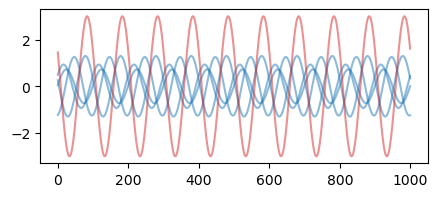

2


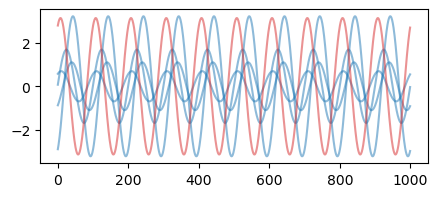

5


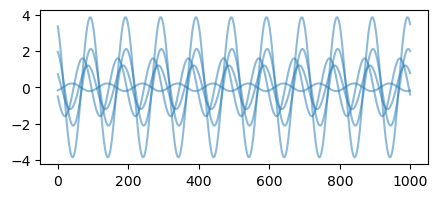

8


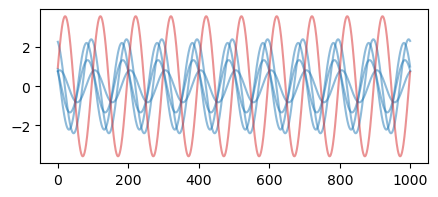

10


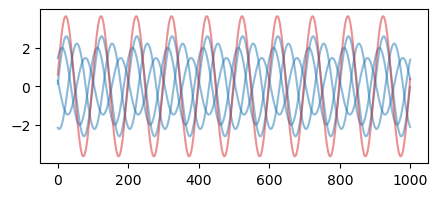

14


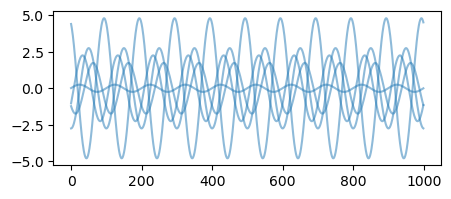

21


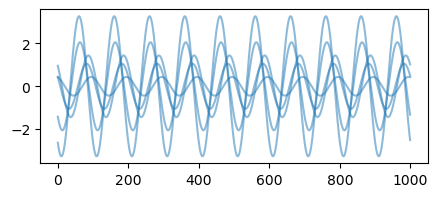

In [209]:
j_ind = 9
for seed in nan_seeds:
    res, zs, xs, obs, mod_cfg = load_debug_data(cfg, seed, K, L, mu)
    nan_trial_bool = jnp.isnan(res['track']['alphas'][0].squeeze().sum(0))
    zs_nz = zs[j_ind,:,:]

    zs_nan = zs_nz[:,nan_trial_bool]
    zs_nonnan = zs_nz[:,~nan_trial_bool]

    xs_nan = xs[:,:,nan_trial_bool]
    xs_nonnan = xs[:,:,~nan_trial_bool]

    obs_nan = obs[:,:,nan_trial_bool]
    obs_nonnan = obs[:,:,~nan_trial_bool]

    k = 0
    fig, ax = plt.subplots(figsize=(5,2))
    for i in range(L - nan_trial_bool.sum()):
        ax.plot(xs_nonnan[:,k,i], color='tab:blue', alpha=0.5)
    for i in range(nan_trial_bool.sum()):
        ax.plot(xs_nan[:,k,i], color='tab:red', alpha=0.5)
    plt.show()
        

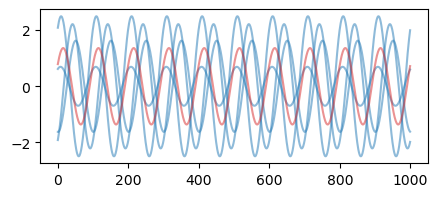

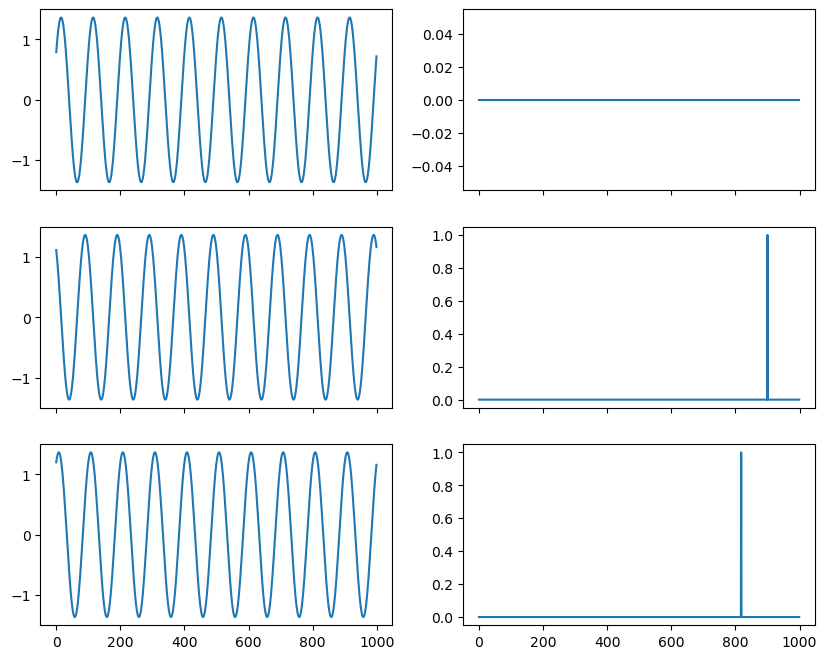

In [186]:
K_show = 3
for i in range(nan_trial_bool.sum()):
    fig, ax = plt.subplots(K_show,2, figsize=(10,8), sharex=True)
    for k in range(K_show):
        ax[k,0].plot(xs_nan[:,k,i])
        ax[k,1].plot(obs_nan[:,k,i])

In [182]:
nan_trial_bool.sum()

Array(1, dtype=int32)

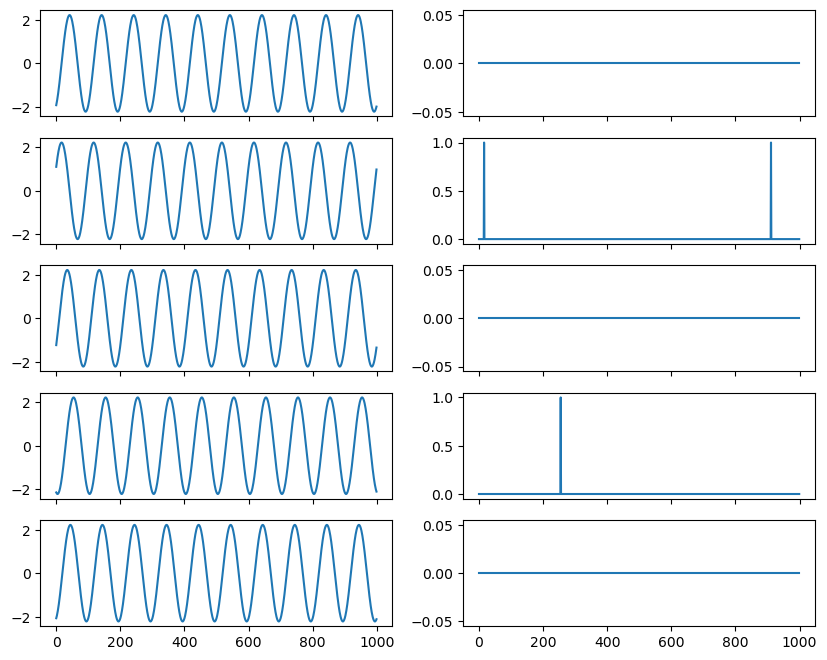

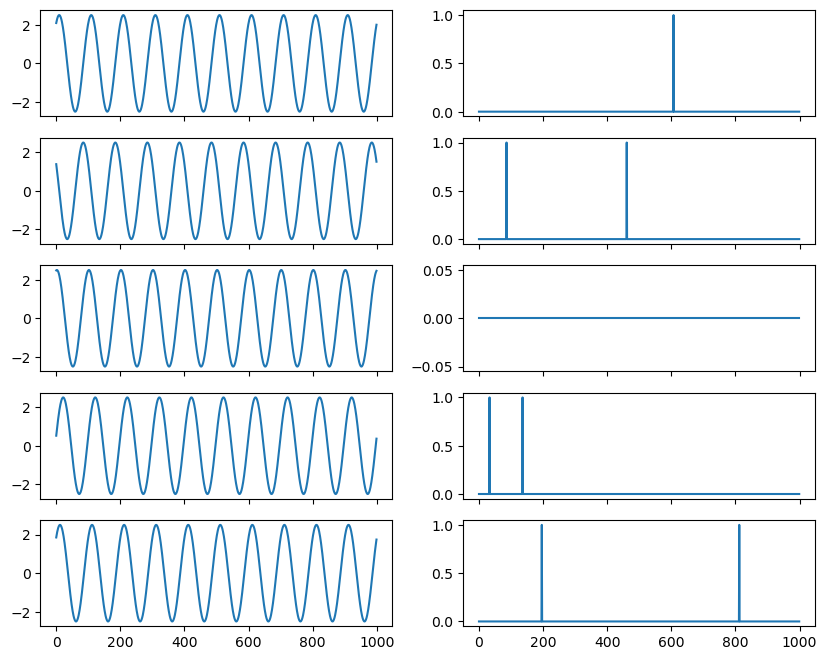

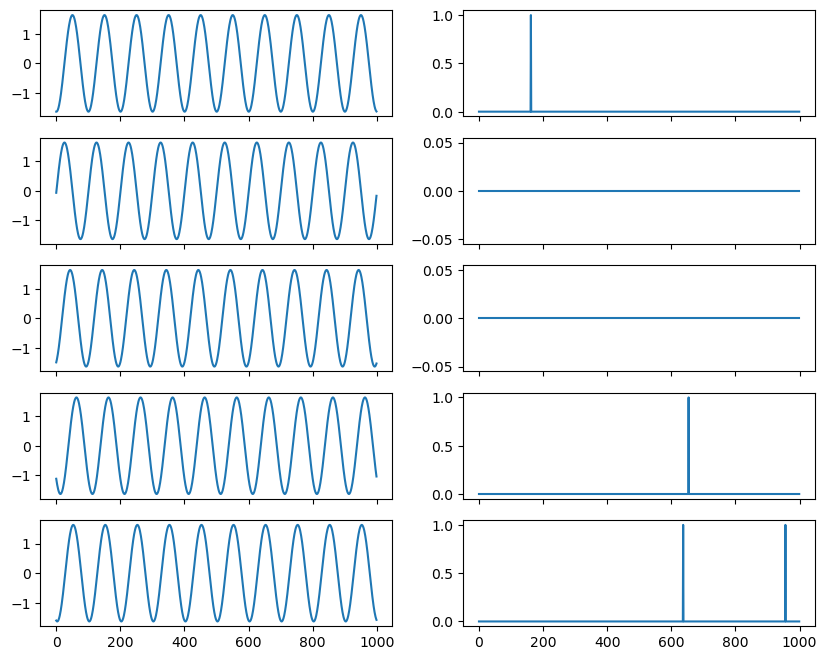

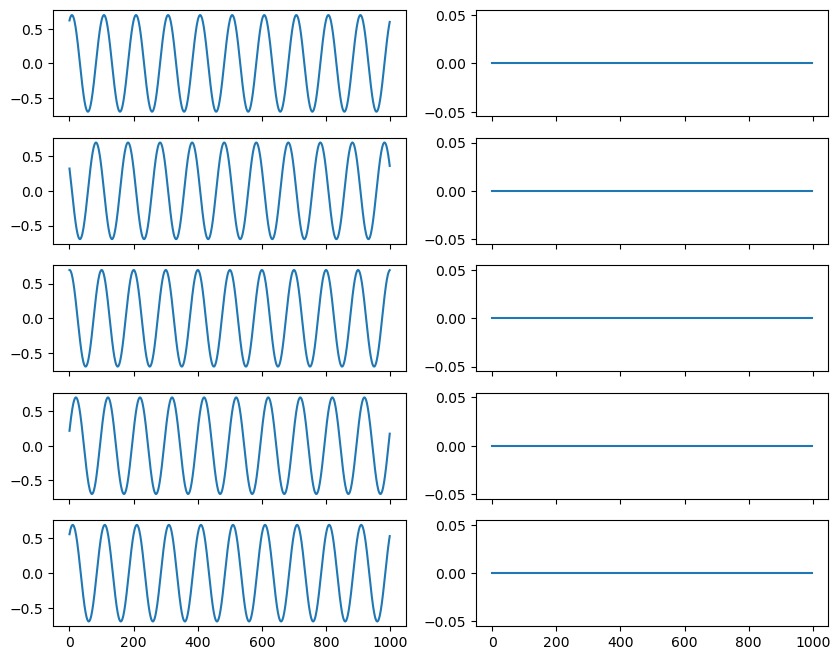

In [184]:
for i in range(L - nan_trial_bool.sum()):
    fig, ax = plt.subplots(K_show,2, figsize=(10,8), sharex=True)
    for k in range(K_show):
        ax[k,0].plot(xs_nonnan[:,k,i])
        ax[k,1].plot(obs_nonnan[:,k,i])
    plt.show()

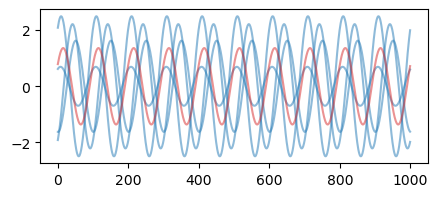

In [187]:
k = 0
fig, ax = plt.subplots(figsize=(5,2))
for i in range(L - nan_trial_bool.sum()):
    ax.plot(xs_nonnan[:,k,i], color='tab:blue', alpha=0.5)
for i in range(nan_trial_bool.sum()):
    ax.plot(xs_nan[:,k,i], color='tab:red', alpha=0.5)
    

# Eigvals

In [9]:
def plot_eigval_var_L_subplot(ax, plot_dict, drop_emp):
    naive_color = 'tab:red'
    naive_style = 'dashed'
    naive_width = 2

    true_color = 'k'
    true_style = 'solid'
    true_width = 2

    oracle_color = 'tab:green'
    oracle_style = 'dotted'
    oracle_width = 2.5

    est_color = 'tab:blue'
    est_style = 'solid'
    est_width = 2

    ev_true = plot_dict['eigval_true']
    ev_oracle = plot_dict['eigval_oracle']
    ev_naive = plot_dict['eigval_naive']
    evs_em = plot_dict['eigvals_em']

    ax.axhline(ev_true, linestyle=true_style, color=true_color, linewidth=true_width)
    ax.axhline(ev_oracle, linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)
    if drop_emp is False:
        ax.axhline(ev_naive, linestyle=naive_style, color=naive_color, linewidth=naive_width)
    ax.plot(evs_em, color=est_color, linestyle=est_style, linewidth=est_width)

In [10]:
from cohlib.plot import get_eigval
eigrank = 1
# thetas = [-2.0, -1.0, 0.0, 1.0, 2.0]
# for mu in 0.8 1.5 2.4 3.1
jind_nz = 0

def get_plot_dict_eigvals(cfg, K, Ls, thetas):
    plot_data = {}
    for l, L in enumerate(Ls):
        for t, theta in enumerate(thetas):
            # print(f'gathering data for K={K}, L={L}, theta={theta}')
            cfg = mod_config(cfg, K, L, theta)

            # context initialization
            nz_model = jnp.array([cfg.latent.target_freq_ind])
            temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
                            'nz_model': nz_model, 'K': cfg.latent.K}
            model_dir = conf.get_model_dir(cfg, temp_params)

            res = pickle_open(os.path.join(model_dir, 'res.pkl'))

            lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
            plot_data[t,l] = {}
            plot_data[t,l]['eigval_true'] = lrccn_true.eigvals[0,eigrank-1] / K
            eigvals_em = jnp.stack([get_ccn_fullrank_eigvals(x)[0,eigrank-1] for x in res['track']['ccn']])
            plot_data[t,l]['eigvals_em'] = eigvals_em / K

            # load zs data and compute oracle est
            latent_dir = conf.get_latent_dir(cfg.latent)
            latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
            zs_nz = latent_load['zs_nz']
            nz_true = latent_load['nz']
            jind_nz = 0

            # TODO fix for 
            gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
            oracle_eigval = get_eigval(gamma_oracle[jind_nz,:,:], eigrank) 
            plot_data[t,l]['eigval_oracle'] = oracle_eigval / K

            obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
            obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
            obs = obs_load['obs']

            if cfg.model.inherit_lcfg is True:
                nz_model = nz_true
            else:
                raise NotImplementedError

            obs_type = cfg.obs.obs_type
            if obs_type == 'gaussian':
                naive_est = naive_estimator(obs, nz_model)
            elif obs_type in ['pp_relu', 'pp_log']:
                naive_est = naive_estimator(obs, nz_model)*1e6
            else:
                raise ValueError
            naive_eigval = get_eigval(naive_est[jind_nz,:,:], eigrank) 
            plot_data[t,l]['eigval_naive'] = naive_eigval / K

    return plot_data



In [11]:
# Get base cfg to modify
gseed_use = 0
seed_use = 0
# scale_power = int(1e6)
# temp = f"/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale{scale_power}/window1000/gseed0/K3/L5/lseed0/obs-pp_log/mu0.8/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
scale_power = int(1e4)
mu = 3.2
temp = f"/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale{scale_power}/window1000/gseed0/K20/L25/lseed0/obs-pp_log/mu{mu}/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
res = pickle_open(temp)
cfg = conf.omega(res['cfg'])

cfg.latent.gamma_seed = gseed_use
cfg.latent.seed = seed_use
cfg.obs.seed = seed_use
nz_model = jnp.array([cfg.latent.target_freq_ind])

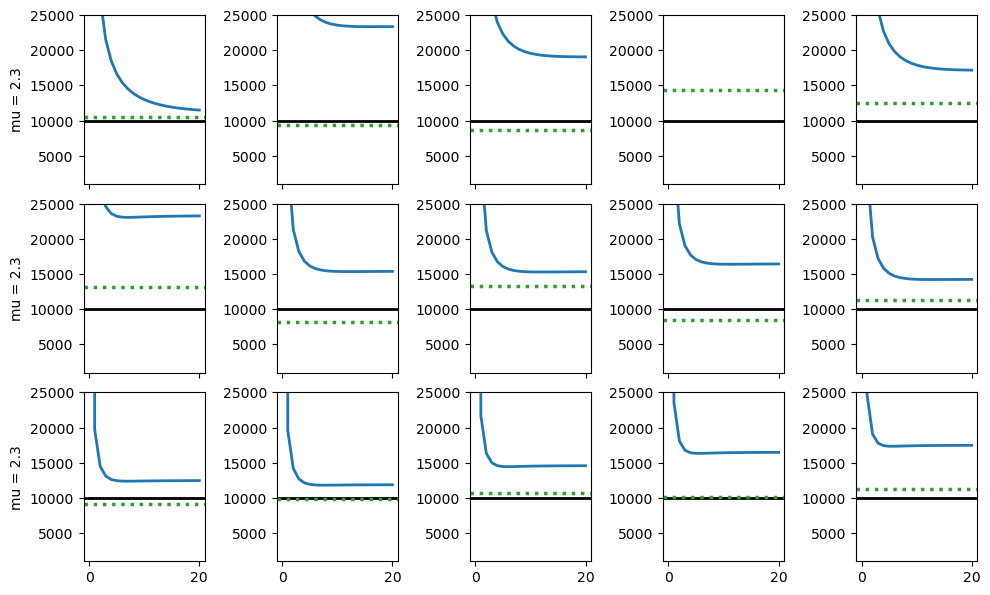

In [16]:
Ls = [25]
L = Ls[0]
l = 0

m = 5
seeds = [x+m for x in range(5)]

Ks = [5, 10, 20]
thetas = [2.3]

fig, ax = plt.subplots(len(Ks), len(seeds), figsize=(10,6), sharex=True, sharey=False)
for k, K in enumerate(Ks):


    for s, seed_use in enumerate(seeds):
        cfg.latent.gamma_seed = gseed_use
        cfg.latent.seed = seed_use
        cfg.obs.seed = seed_use
        nz_model = jnp.array([cfg.latent.target_freq_ind])
        plot_data = get_plot_dict_eigvals(cfg, K, Ls, thetas)
        for t, theta in enumerate(thetas):
            # ax[k,s].set_yscale('log')

            plot_eigval_var_L_subplot(ax[k,s], plot_data[t,l], drop_emp=False)

            if s == 0:
                ax[k,s].set_ylabel(f'{get_theta_label(cfg.obs, theta)}')
            ax[k,s].set_ylim([1000, 25000])
            # if t == 0:
plt.tight_layout()
                # ax[k,s].set_title(f'seed = {seed_use}; L = {L}')
            # if t == len(thetas)-1:
            #     ax[k,s].set_xlabel('EM Iter')


In [56]:
def get_ccn_fullrank_eigvecs(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    _, eigvecs_raw = jnp.linalg.eigh(gamma)
    eigvecs = eigvecs_raw[:,:,::-1]
    return eigvecs

def plot_eigvec_var_L_subplot(ax, plot_dict, dim, func, funcname):
    naive_color = 'tab:red'
    naive_style = 'dashed'
    naive_width = 2

    true_color = 'k'
    true_style = 'solid'
    true_width = 2

    oracle_color = 'tab:green'
    oracle_style = 'dotted'
    oracle_width = 2.5

    est_color = 'tab:blue'
    est_style = 'solid'
    est_width = 2

    ev_true = plot_dict['eigvec_true']
    ev_oracle = plot_dict['eigvec_oracle']
    ev_naive = plot_dict['eigvec_naive']
    evs_em = plot_dict['eigvecs_em']

    func_eigvecs_em = jnp.stack([func(x[dim]) for x in evs_em])

    ax.axhline(func(ev_true[dim]), linestyle=true_style, color=true_color, linewidth=true_width)
    ax.axhline(func(ev_oracle[dim]), linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)
    ax.axhline(func(ev_naive[dim]), linestyle=naive_style, color=naive_color, linewidth=naive_width)
    ax.plot(func_eigvecs_em, color=est_color, linestyle=est_style, linewidth=est_width)

In [57]:
from cohlib.plot import get_eigvec
def get_plot_dict_eigvecs(cfg, K, Ls, theta):
    plot_data = {}

    for l, L in enumerate(Ls):
        for t, theta in enumerate(thetas):
            print(f'gathering data for L={L}, theta={theta}')
            cfg = mod_config(cfg, K, L, theta)

            # context initialization
            nz_model = jnp.array([cfg.latent.target_freq_ind])
            temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
                            'nz_model': nz_model, 'K': cfg.latent.K}
            model_dir = conf.get_model_dir(cfg, temp_params)

            res = pickle_open(os.path.join(model_dir, 'res.pkl'))

            # load result value
            # load true value
            lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
            plot_data[t,l] = {}
            plot_data[t,l]['eigvec_true'] = lrccn_true.eigvecs[0,:,eigrank-1]
            if cfg.plot.rotate is True:
                eigvecs_em = jnp.stack([rotate_eigvecs(get_ccn_fullrank_eigvecs(x))[0,:,eigrank-1] for x in res['track']['ccn']])
            else:
                eigvecs_em = jnp.stack([get_ccn_fullrank_eigvecs(x)[0,:,eigrank-1] for x in res['track']['ccn']])
            plot_data[t,l]['eigvecs_em'] = eigvecs_em

            # load zs data and compute oracle est
            latent_dir = conf.get_latent_dir(cfg.latent)
            latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
            zs_nz = latent_load['zs_nz']
            nz_true = latent_load['nz']
            jind_nz = 0

            # TODO fix for 
            gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
            oracle_eigvec = get_eigvec(gamma_oracle[jind_nz,:,:], eigrank)
            oracle_eigvec = oracle_eigvec*jnp.exp(-1j*jnp.angle(oracle_eigvec[0]))
            plot_data[t,l]['eigvec_oracle'] = oracle_eigvec

            obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
            obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
            obs = obs_load['obs']

            if cfg.model.inherit_lcfg is True:
                nz_model = nz_true
            else:
                raise NotImplementedError

            obs_type = cfg.obs.obs_type
            if obs_type == 'gaussian':
                naive_est = naive_estimator(obs, nz_model)
            elif obs_type in ['pp_relu', 'pp_log']:
                naive_est = naive_estimator(obs, nz_model)*1e6
            else:
                raise ValueError
            naive_eigvec = get_eigvec(naive_est[jind_nz,:,:], eigrank)
            naive_eigvec = naive_eigvec*jnp.exp(-1j*jnp.angle(naive_eigvec[0]))
            plot_data[t,l]['eigvec_naive'] = naive_eigvec
    return plot_data

gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2


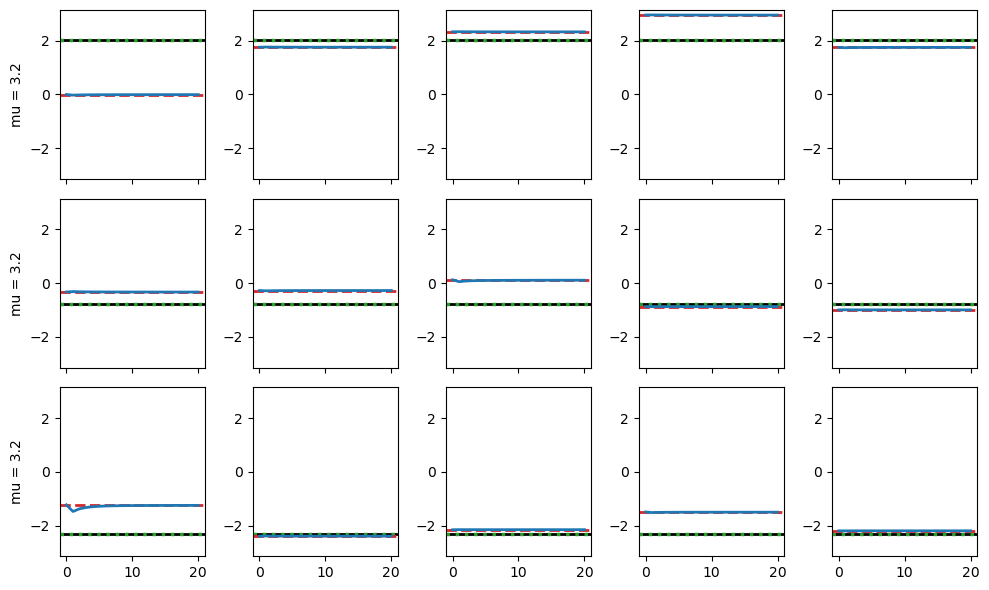

In [71]:
dim = 3
func = jnp.angle
Ls = [25]
L = Ls[0]
l = 0

Ks = [5, 10, 20]
thetas = [3.2]

cfg.plot = {}
cfg.plot.rotate = True
fig, ax = plt.subplots(len(Ks), len(seeds), figsize=(10,6), sharex=True, sharey=False)
for k, K in enumerate(Ks):


    for s, seed_use in enumerate(seeds):
        cfg.latent.gamma_seed = gseed_use
        cfg.latent.seed = seed_use
        cfg.obs.seed = seed_use
        nz_model = jnp.array([cfg.latent.target_freq_ind])
        plot_data = get_plot_dict_eigvecs(cfg, K, Ls, thetas)
        for t, theta in enumerate(thetas):
            # ax[k,s].set_yscale('log')

            plot_eigvec_var_L_subplot(ax[k,s], plot_data[t,l], dim, func, 'angle')

            if s == 0:
                ax[k,s].set_ylabel(f'{get_theta_label(cfg.obs, theta)}')
            ax[k,s].set_ylim([-jnp.pi, jnp.pi])
            # if t == 0:
plt.tight_layout()
                # ax[k,s].set_title(f'seed = {seed_use}; L = {L}')
            # if t == len(thetas)-1:
            #     ax[k,s].set_xlabel('EM Iter')


gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2
gathering data for L=25, theta=3.2


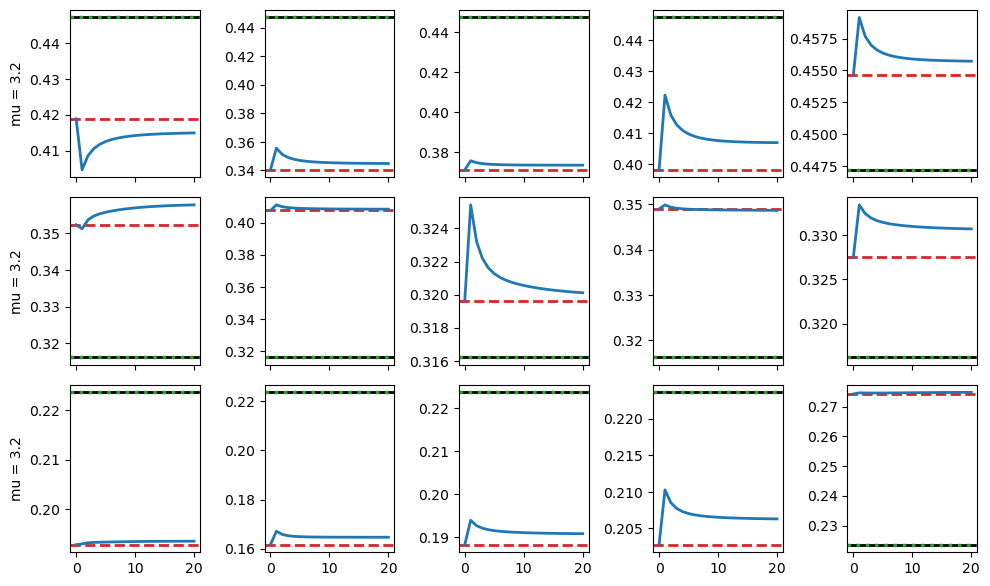

In [76]:
dim = 3
func = jnp.abs
Ls = [25]
L = Ls[0]
l = 0

Ks = [5, 10, 20]
thetas = [3.2]

cfg.plot = {}
cfg.plot.rotate = True
fig, ax = plt.subplots(len(Ks), len(seeds), figsize=(10,6), sharex=True, sharey=False)
for k, K in enumerate(Ks):


    for s, seed_use in enumerate(seeds):
        cfg.latent.gamma_seed = gseed_use
        cfg.latent.seed = seed_use
        cfg.obs.seed = seed_use
        nz_model = jnp.array([cfg.latent.target_freq_ind])
        plot_data = get_plot_dict_eigvecs(cfg, K, Ls, thetas)
        for t, theta in enumerate(thetas):
            # ax[k,s].set_yscale('log')

            plot_eigvec_var_L_subplot(ax[k,s], plot_data[t,l], dim, func, 'magnitude')

            if s == 0:
                ax[k,s].set_ylabel(f'{get_theta_label(cfg.obs, theta)}')
            # ax[k,s].set_ylim([-jnp.pi, jnp.pi])
            # if t == 0:
plt.tight_layout()
                # ax[k,s].set_title(f'seed = {seed_use}; L = {L}')
            # if t == len(thetas)-1:
            #     ax[k,s].set_xlabel('EM Iter')


In [33]:
cfg['plot'] = {}
cfg.plot.rotate = True


gathering data for L=5, theta=0.8
gathering data for L=5, theta=1.5
gathering data for L=5, theta=2.4
gathering data for L=5, theta=3.1
gathering data for L=5, theta=0.8
gathering data for L=5, theta=1.5
gathering data for L=5, theta=2.4
gathering data for L=5, theta=3.1
gathering data for L=5, theta=0.8
gathering data for L=5, theta=1.5
gathering data for L=5, theta=2.4
gathering data for L=5, theta=3.1


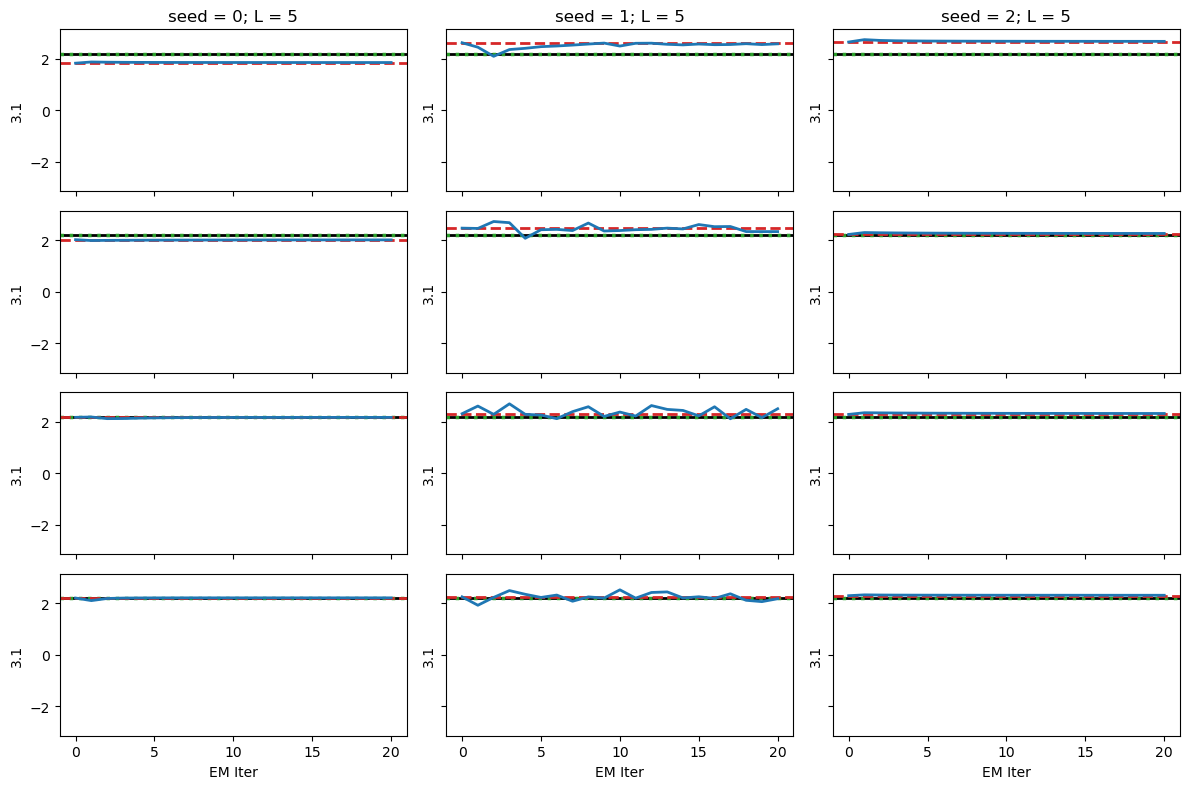

In [34]:
nseeds = 3
seeds = [x + nseeds*m for x in range(nseeds)]

funcs = [jnp.angle, jnp.abs, jnp.real, jnp.imag]
funcnames = ['Phase', 'Mag', 'Real', 'Imag']

f = 0
func, funcname = funcs[f], funcnames[f]
dim = 1


fig, ax = plt.subplots(len(thetas), len(seeds), figsize=(12,8), sharex=True, sharey='row')

# for l, L in enumerate(Ls):
l = 0
L = Ls[0]
for s, seed_use in enumerate(seeds):
    cfg.latent.gamma_seed = gseed_use
    cfg.latent.seed = seed_use
    cfg.obs.seed = seed_use
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    plot_data = get_plot_dict_eigvecs(cfg)

    for t, theta in enumerate(thetas):
        axp = ax[t,s]

        plot_eigvec_var_L_subplot(ax[t,s], plot_data[t,l], dim, func, funcname)

        if l == 0:
            ax[t,s].set_ylabel(f'{get_theta_label(cfg.obs, theta)}')
        if t == 0:
            ax[t,s].set_title(f'seed = {seed_use}; L = {L}')
        if t == len(thetas)-1:
            ax[t,s].set_xlabel('EM Iter')
        if funcname == 'Phase':
            ax[t,s].set_ylim([-jnp.pi,jnp.pi])

plt.tight_layout()